# Paleopandas Playground

The goal of this notebook is to explore the uses of pandas within Pyleoclim, particularly since the implementation of non-nanosecond time resolutions that allow for geological and cosmological time scales to be represented within NumPy/Pandas (references needed)

In [1]:
%load_ext autoreload
%load_ext watermark
%autoreload 2

import pandas as pd
import pyleoclim as pyleo
import datetime
import numpy

## Series creation:

We start by creating a series, reading values from a CSV file and adding metadata manually:

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: xlabel='Time [years CE]', ylabel='SOI [mb]'>)

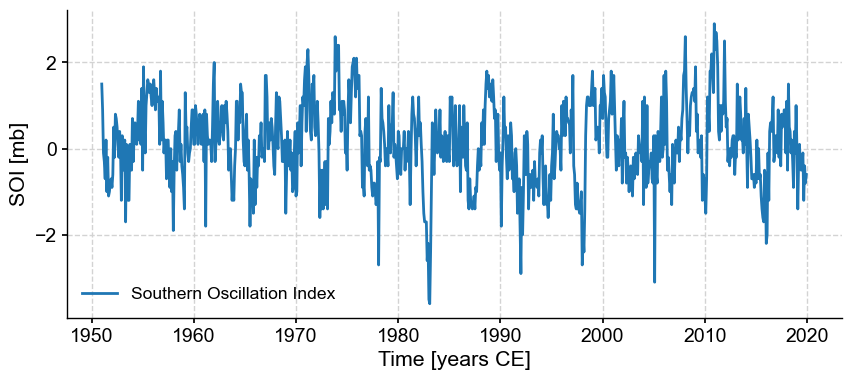

In [2]:
data=pd.read_csv(
    "../data/soi_data.csv",
    skiprows=0, header=1
)
time=data.iloc[:,1]
value=data.iloc[:,2]

darwin_lon = 130.8444
darwin_lat = -12.4637
tahiti_lon = 149.4260
tahiti_lat = -17.6509 
# compute centroid : https://stackoverflow.com/a/38201499


ts=pyleo.Series(
    time=time, value=value,
    time_name="Time", time_unit='years CE',
    value_name="SOI", value_unit = 'mb',
    label="Southern Oscillation Index", 
)
ts.plot()

New properties attached to `pyleo.Series` objects:
1. a pandas datetime_index:

In [3]:
ts.datetime_index

DatetimeIndex(['1951-01-01 00:00:00', '1951-01-31 10:29:49',
               '1951-03-02 21:00:10', '1951-04-02 07:30:00',
               '1951-05-02 17:59:49', '1951-06-02 04:30:10',
               '1951-07-02 15:00:00', '1951-08-02 01:29:49',
               '1951-09-01 12:00:10', '1951-10-01 22:30:00',
               ...
               '2019-03-02 21:00:10', '2019-04-02 07:30:00',
               '2019-05-02 17:59:49', '2019-06-02 04:30:10',
               '2019-07-02 15:00:00', '2019-08-02 01:29:49',
               '2019-09-01 12:00:10', '2019-10-01 22:30:00',
               '2019-11-01 08:59:49', '2019-12-01 19:30:10'],
              dtype='datetime64[s]', name='datetime', length=828, freq=None)

2. a dictionary bundling all the metadata:

In [4]:
ts.metadata

{'time_unit': 'years CE',
 'time_name': 'Time',
 'value_unit': 'mb',
 'value_name': 'SOI',
 'label': 'Southern Oscillation Index',
 'lat': None,
 'lon': None,
 'archiveType': None,
 'importedFrom': None,
 'log': ({0: 'clean_ts', 'applied': True, 'verbose': False},)}

When invoking the object itself, the `__repr__` method is called, showing some essential metadata and a compressed view of the data:   

In [5]:
ts

{'label': 'Southern Oscillation Index',
 'log': ({0: 'clean_ts', 'applied': True, 'verbose': False},)}


None
Time [years CE]
1951.000000    1.5
1951.083333    0.9
1951.166667   -0.1
1951.250000   -0.3
1951.333333   -0.7
              ... 
2019.583333   -0.1
2019.666667   -1.2
2019.750000   -0.4
2019.833333   -0.8
2019.916667   -0.6
Name: SOI [mb], Length: 828, dtype: float64

## from_pandas()

We can also create this object from a Pandas Series. `data` is a pandas DataFrame, but its index is not currently a datetime index:

In [6]:
data.head()

,Date,Year,Value
0,195101,1951.000000,1.5
1,195102,1951.083333,0.9
2,195103,1951.166667,-0.1
3,195104,1951.250000,-0.3
4,195105,1951.333333,-0.7


Let's generate this index by hand, imposing a `datetime64[s]` dtype to test things out for paleo applications:

In [7]:
idx = pd.date_range('15-01-1951',periods=len(time), freq='M', unit='s') # default would be a nano-second dtype
idx.dtype

dtype('<M8[s]')

In [8]:
SOI_series = pd.Series(data=value.set_axis(idx), name = 'SOI')
SOI_series

1951-01-31    1.5
1951-02-28    0.9
1951-03-31   -0.1
1951-04-30   -0.3
1951-05-31   -0.7
             ... 
2019-08-31   -0.1
2019-09-30   -1.2
2019-10-31   -0.4
2019-11-30   -0.8
2019-12-31   -0.6
Freq: M, Name: SOI, Length: 828, dtype: float64

In [9]:
type(SOI_series.values)

numpy.ndarray

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: xlabel='Time [years CE]', ylabel='SOI [mb]'>)

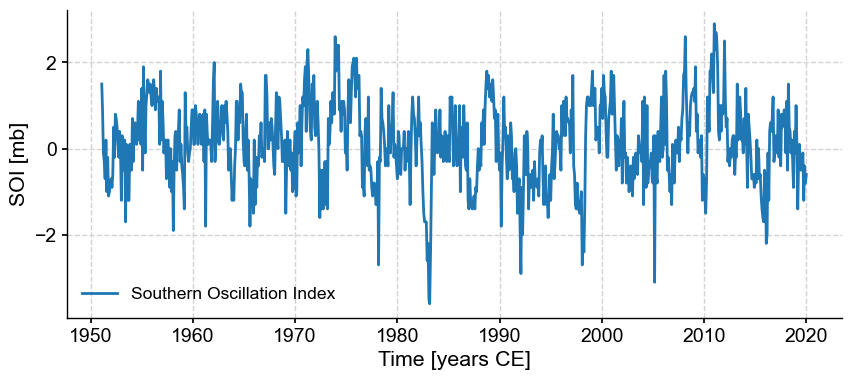

In [10]:
SOI_pd = pyleo.Series.from_pandas(ser=SOI_series, metadata=ts.metadata)
SOI_pd.plot()

We can see that all the data and metadata made it into the object, as they should.

## to_pandas()

conversely, one can export from pyleo.Series to a pandas Series:

In [11]:
pdts = ts.to_pandas() #  returns just the Series ; metadata are available at ts.metadata
type(pdts) 

pandas.core.series.Series

It is now a bona fide Pandas series, and we can do with it everything we might do with pandas, like:

In [12]:
pdts.head()

datetime
1951-01-01 00:00:00    1.5
1951-01-31 10:29:49    0.9
1951-03-02 21:00:10   -0.1
1951-04-02 07:30:00   -0.3
1951-05-02 17:59:49   -0.7
Name: SOI, dtype: float64

In [13]:
pdts.describe()

count    828.000000
mean       0.119928
std        0.938586
min       -3.600000
25%       -0.500000
50%        0.100000
75%        0.800000
max        2.900000
Name: SOI, dtype: float64

## Unit conversions

This new version of Pyleoclim also features enhanced coversions betwen time representations:

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: xlabel='Age [yrs BP]', ylabel='SOI [mb]'>)

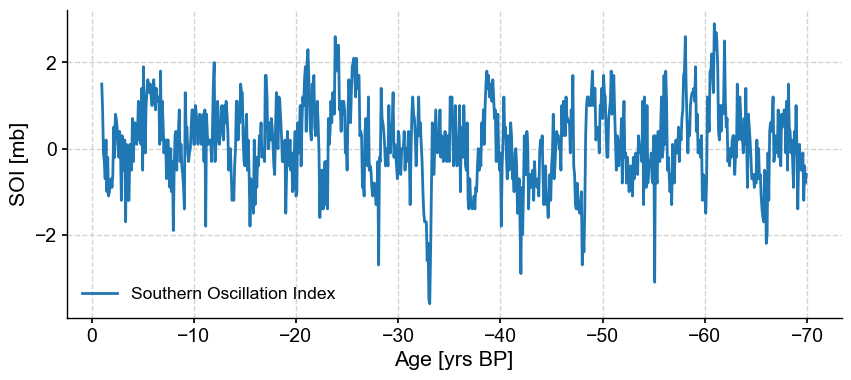

In [14]:
tsBP = ts.convert_time_unit('yrs BP')
tsBP.plot(invert_xaxis=True) # by default, plots represent values in increasing order, so we reverse the x-axis

In [15]:
tsBP.datetime_index

DatetimeIndex(['2019-12-01 19:30:09', '2019-11-01 08:59:49',
               '2019-10-01 22:30:00', '2019-09-01 12:00:09',
               '2019-08-02 01:29:49', '2019-07-02 15:00:00',
               '2019-06-02 04:30:09', '2019-05-02 17:59:49',
               '2019-04-02 07:30:00', '2019-03-02 21:00:09',
               ...
               '1951-10-01 22:30:00', '1951-09-01 12:00:10',
               '1951-08-02 01:29:49', '1951-07-02 15:00:00',
               '1951-06-02 04:30:10', '1951-05-02 17:59:48',
               '1951-04-02 07:30:00', '1951-03-02 21:00:09',
               '1951-01-31 10:29:48', '1951-01-01 00:00:00'],
              dtype='datetime64[s]', name='datetime', length=828, freq=None)

Notice how the datetime index is unchanged by the time unit conversion: no matter what the units, the timestamps are fixed and absolute. `ts.time` is the only thing that does change, and is used for display purposes, including here:

In [16]:
tsBP

{'label': 'Southern Oscillation Index',
 'log': ({0: 'clean_ts', 'applied': True, 'verbose': False},)}


None
Age [yrs BP]
-69.916667   -0.6
-69.833333   -0.8
-69.750000   -0.4
-69.666667   -1.2
-69.583333   -0.1
             ... 
-1.333333    -0.7
-1.250000    -0.3
-1.166667    -0.1
-1.083333     0.9
-1.000000     1.5
Name: SOI [mb], Length: 828, dtype: float64

## Irregularly sampled series

Let us make sure that pandas' abilities are not thrown off by irregular spacing

In [63]:
path = 'ftp://ftp.ncdc.noaa.gov/pub/data/paleo/icecore/antarctica/antarctica2015co2composite.txt'
co2df = pd.read_csv(path, skiprows=137, sep='\t')
co2df.head()

,age_gas_calBP,co2_ppm,co2_1s_ppm
0,-51.03,368.02,0.06
1,-48.00,361.78,0.37
2,-46.28,359.65,0.10
3,-44.41,357.11,0.16
4,-43.08,353.95,0.04


(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: xlabel='Age [kyr BP]', ylabel='$CO_2$ [ppm]'>)

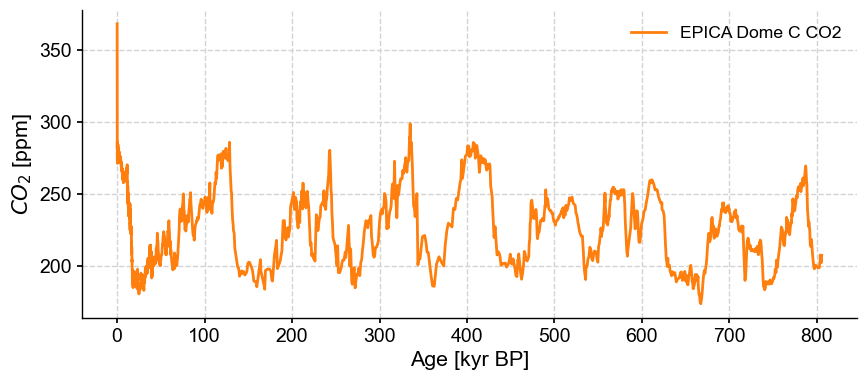

In [64]:
co2ts = pyleo.Series(time=co2df['age_gas_calBP']/1000,value= co2df['co2_ppm'],
                     time_name='Age',time_unit='kyr BP',value_name = r'$CO_2$',
                     value_unit='ppm',label='EPICA Dome C CO2')
co2ts.plot(color='C1')

In [65]:
co2ts.datetime_index

DatetimeIndex([   '2001-01-11 22:58:48',    '1998-01-01 00:00:00',
                  '1996-04-12 06:28:48',    '1994-05-30 18:03:35',
                  '1993-01-30 05:16:47',    '1992-04-23 05:27:36',
                  '1991-02-17 11:34:48',    '1989-12-21 07:01:11',
                  '1989-05-30 18:03:35',    '1988-12-20 07:01:11',
               ...
               '-795429-03-07 11:52:49', '-796732-09-13 10:12:00',
               '-799287-12-10 02:02:24', '-800923-11-29 03:03:37',
               '-801760-10-01 16:30:00', '-801976-09-20 17:31:12',
               '-802060-02-18 05:34:49', '-802573-05-01 06:46:48',
               '-803183-07-24 06:57:37', '-803719-02-17 05:34:49'],
              dtype='datetime64[s]', name='datetime', length=1901, freq=None)

Default display of the series:

In [66]:
co2ts

{'label': 'EPICA Dome C CO2',
 'log': ({0: 'clean_ts', 'applied': True, 'verbose': False},)}


None
Age [kyr BP]
-0.05103      368.02
-0.04800      361.78
-0.04628      359.65
-0.04441      357.11
-0.04308      353.95
               ...  
 803.92528    202.92
 804.00987    207.50
 804.52267    204.86
 805.13244    202.23
 805.66887    207.29
Name: $CO_2$ [ppm], Length: 1901, dtype: float64

For a prettier display of the actual data, one can do:

In [67]:
co2ts.view()

,$CO_2$ [ppm]
Age [kyr BP],
-0.05103,368.02
-0.04800,361.78
-0.04628,359.65
-0.04441,357.11
-0.04308,353.95
...,...
803.92528,202.92
804.00987,207.50
804.52267,204.86


## CSV Import/Export

### to CSV

In [68]:
co2ts.to_csv()

Series exported to ./EPICA_Dome_C_CO2.csv


### from CSV
One should be able to read the file back in and get the same result:

In [69]:
co2ts2 = pyleo.Series.from_csv(filename='EPICA_Dome_C_CO2.csv')
co2ts2.equals(co2ts) # showcasing the use of the 'equals' method

Difference found among the 2 Series'' data


False

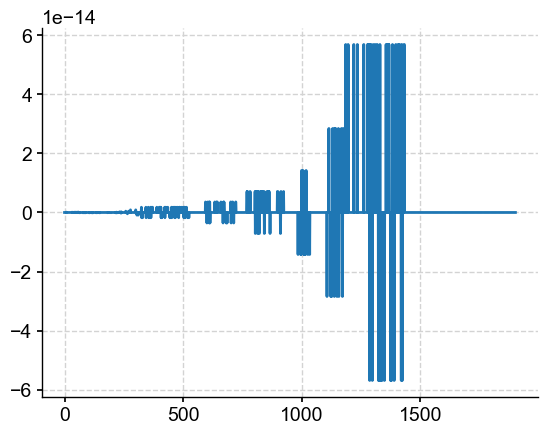

In [77]:
import matplotlib.pyplot as plt
plt.plot(co2ts2.time-co2ts.time)

**Question for Marco/Kim**: why do the two Series have slightly different time axes?

## Resampling

Let's use [resample()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html) to obtain yearly averages:

/Users/julieneg/Documents/GitHub/Pyleoclim_util/pyleoclim/utils/tsutils.py:79: UserWarning: Time unit years CE not recognized. Defaulting to years CE
  warnings.warn(f'Time unit {time_unit} not recognized. Defaulting to years CE')


<AxesSubplot: xlabel='Time [years CE]', ylabel='SOI [mb]'>

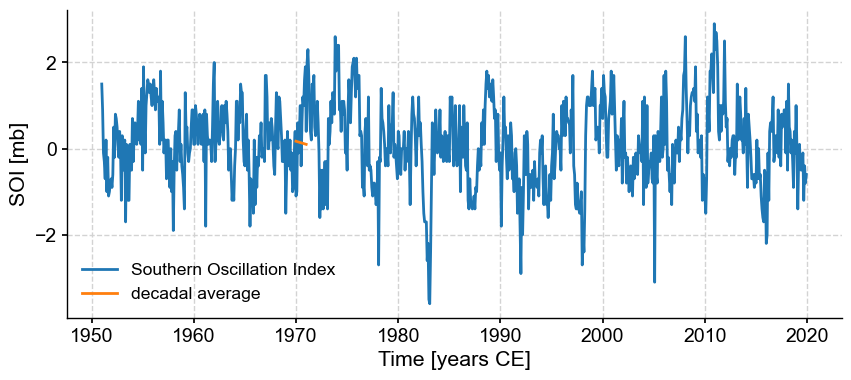

In [52]:
ts10 = ts.pandas_method(lambda x: x.resample('Y').mean())
ts10.label = 'decadal average'
fig, ax = ts.plot()
ts10.plot(ax=ax)

**Question for Marco**: can you investigate why the resampling didn't work here?

In [ ]:
%watermark -n -u -v -iv -w